<a href="https://colab.research.google.com/github/IamKishoreSreedharan/food-lens/blob/main/data_scraping_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from pathlib import Path
from tqdm import tqdm
import hashlib

In [5]:
DIR = '/content/drive/MyDrive/project/'

In [6]:
# Create organized subdirectories
# os.makedirs(os.path.join(DIR, "images"), exist_ok=True)          # For downloaded images
# os.makedirs(os.path.join(DIR, "data"), exist_ok=True)            # For CSVs
# os.makedirs(os.path.join(DIR, "models/classifier"), exist_ok=True)          # For autoencoder weights
# os.makedirs(os.path.join(DIR, "models/cbir"), exist_ok=True)
# os.makedirs(os.path.join(DIR, "latent_features"), exist_ok=True) # For feature vectors
SRC_FILENAME = 'data/recipe.csv'

In [7]:
df_recipe = pd.read_csv(DIR + SRC_FILENAME, low_memory=False)

In [8]:
df_recipe.dtypes

,0
title,object
url,object
category,object
author,object
description,object
rating,float64
rating_count,int64
review_count,int64
ingredients,object
directions,object


In [9]:
df_recipe.isna().sum()

,0
title,0
url,0
category,0
author,39
description,0
rating,0
rating_count,0
review_count,0
ingredients,0
directions,0


In [12]:
# Create a unique ID for each recipe
df_recipe["recipe_id"] = df_recipe["image"].astype(str).apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()[:10]
)

In [13]:
essential_cols = [
    "recipe_id", "title", "ingredients", "directions",
    "prep_time", "cook_time", "total_time", "servings",
    "image", "category",'instructions_list','calories', 'carbohydrates_g', 'sugars_g', 'fat_g',
    'protein_g',  'url', "rating"
]

In [14]:
df_recipe = df_recipe[essential_cols]

In [16]:
nutritional_cols = [
    'calories', 'carbohydrates_g', 'sugars_g', 'fat_g',
    'protein_g'
]

# Calculate mean per category
category_means = df_recipe.groupby('category')[nutritional_cols].mean()

# Impute missing values
for col in nutritional_cols:
    df_recipe[col] = df_recipe.apply(
        lambda row: category_means.loc[row['category'], col] if pd.isna(row[col]) else row[col],
        axis=1
    )

print("Null counts after cleaning:")
print(df_recipe[nutritional_cols].isna().sum())

Null counts after cleaning:
calories           0
carbohydrates_g    0
sugars_g           0
fat_g              0
protein_g          0
dtype: int64


## What We’re Doing with `classify_diet`

### The Goal
We’re creating a system to label each recipe in our entry dataset with one of 6 diet categories—like `LCHFib` (Low-Calorie High-Fiber) or `Junk`—based on its nutritional stats (calories, carbs, sugars, fat, protein). This `classify_diet` function is our rule-based chef, figuring out which diet fits best.

### Why It Matters
- **Labeling the Data**: Our scraped `recipe.csv` might not have diet labels—or they’re messy. This gives us a solid `diet` column to work with.
- **Two-Model Power**:
  - **Nutrition Model**: Uses these labels to train on 1x5 “nutrition images” and predict diets.
  - **CBIR Model**: Gets context—do similar images match diet-wise? (Bonus check.)
- **3-Day Crunch**: With time tight, this quick scoring beats manual labeling or hunting for a perfect dataset.

### How It Works
- **Diet Profiles**: Each diet (e.g., `HCLF` = high carbs, low fat) has a nutritional “vibe.”
- **Scoring**: We rate how well a recipe’s numbers match each diet. High carbs boost `HCLF`, low fat helps `LCHFib`, tons of sugar screams `Junk`. Highest score wins.
- **Rules**: Simple cutoffs (e.g., carbs ≥ 40g = high) guide the scoring—rough but effective.

### Where It Fits
- **Step 1**: Builds `recipe.csv` with diet labels for all recipes.
- **Step 2**: Feeds the nutrition model (training target) and CBIR model (validation bonus).
- **Step 3**: Lets us check model predictions against these rules later.

This is our fast track to a labeled dataset—ready to roll for FoodLens!

In [17]:
# Improved scoring function
def classify_diet(row):
    cals = row.get('calories', 0)
    carbs = row.get('carbohydrates_g', 0)
    sugars = row.get('sugars_g', 0)
    fat = row.get('fat_g', 0)
    prot = row.get('protein_g', 0)

    scores = {
        'HCLF': 0, 'HPLC': 0, 'Balanced': 0, 'LCHF': 0, 'LCHFib': 0, 'Junk': 0
    }

    # Carbs Scoring
    if carbs >= 40:
        scores['HCLF'] += 3
        scores['HPLC'] -= 2
        scores['LCHF'] -= 3
    elif carbs <= 15:
        scores['HPLC'] += 3
        scores['LCHF'] += 3
        scores['HCLF'] -= 3
    else:
        scores['Balanced'] += 2

    # Fat Scoring
    if fat <= 10:
        scores['HCLF'] += 2
        scores['LCHFib'] += 2
        scores['Balanced'] += 1
    elif fat >= 15:
        scores['LCHF'] += 3
        scores['Junk'] += 2
    else:
        scores['Balanced'] += 1

    # Protein Scoring
    if prot >= 20:
        scores['HPLC'] += 3
        scores['HCLF'] -= 1
    elif 10 <= prot <= 20:
        scores['Balanced'] += 2
        scores['LCHF'] += 2

    # Calories Scoring
    if cals <= 200:
        scores['LCHFib'] += 3
        scores['Junk'] -= 2
    elif cals > 300:
        scores['Junk'] += 3
        scores['LCHFib'] -= 2

    # Sugar Scoring
    if sugars >= 25:
        scores['Junk'] += 3
        scores['HCLF'] -= 2
        scores['HPLC'] -= 2
        scores['LCHF'] -= 2
    elif sugars <= 10:
        scores['LCHFib'] += 2

    return max(scores, key=scores.get)

In [18]:
df_recipe['diet'] = df_recipe.apply(classify_diet, axis=1)

In [19]:
df_recipe['diet'].value_counts()

,count
diet,
Junk,10098
LCHFib,9970
LCHF,4356
HPLC,3419
Balanced,2759
HCLF,2120


Basic Statistics:
                       mean         std  min    25%    50%    75%    95%  \
calories         323.985038  212.255646  0.1  173.4  287.2  428.0  705.6   
carbohydrates_g   29.386852   24.059155  0.0   11.8   25.2   41.2   71.6   
sugars_g          10.290647   13.082826  0.0    2.2    5.3   13.3   36.7   
fat_g             16.928359   14.560073  0.0    7.0   13.6   23.1   43.4   
protein_g         14.503453   14.224607  0.0    3.8    9.2   22.6   41.1   

                    max    IQR        CV  
calories         4709.2  254.6  0.655140  
carbohydrates_g   578.2   29.4  0.818705  
sugars_g          212.7   11.1  1.271332  
fat_g             383.9   16.1  0.860100  
protein_g         273.2   18.8  0.980774  


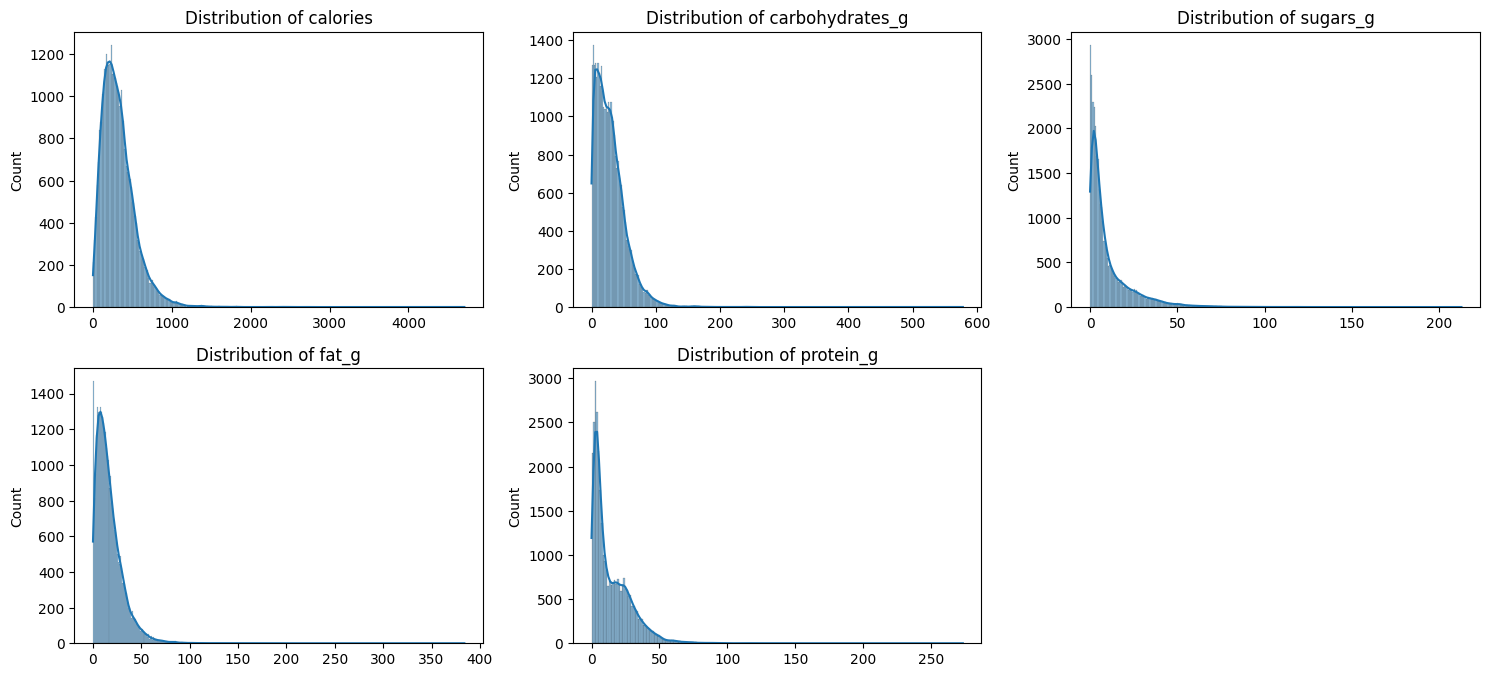

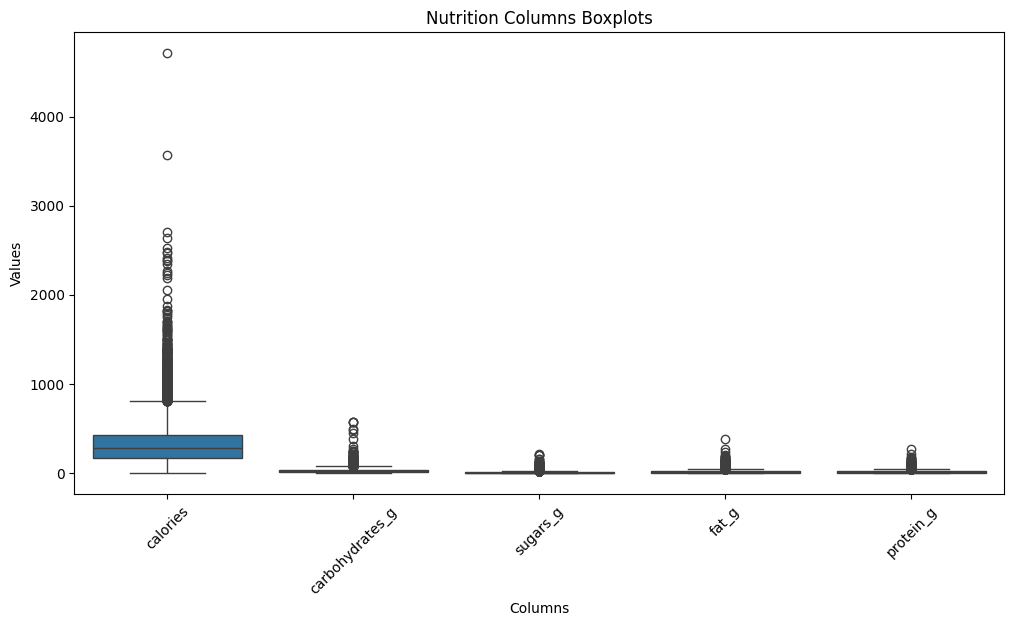

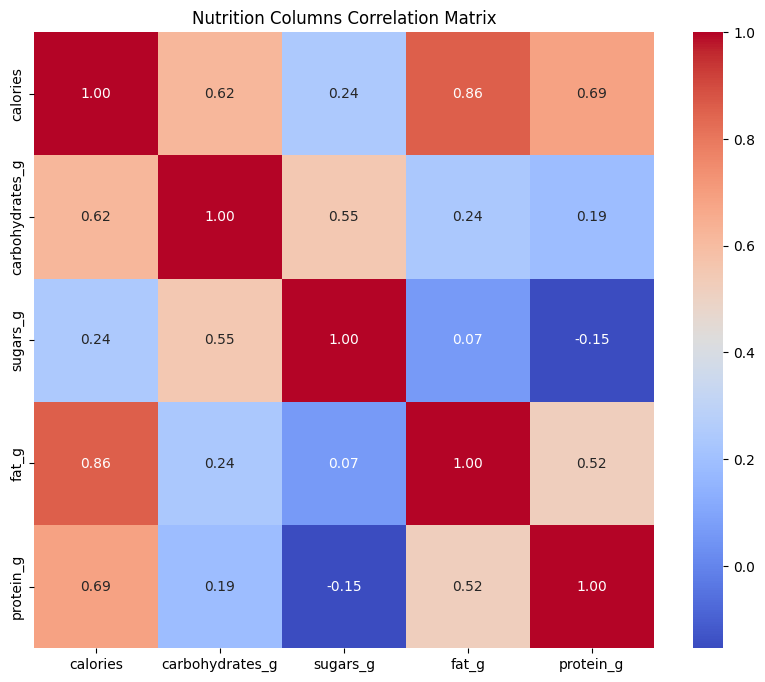

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_nutrition_columns(df):
    # List of nutrition columns to analyze
    nutrition_cols = [
        'calories',
        'carbohydrates_g',
        'sugars_g',
        'fat_g',
        'protein_g',
    ]

    # 1. Basic Statistics
    print("Basic Statistics:")
    stats = df[nutrition_cols].describe(percentiles=[.25, .5, .75, .95]).T
    stats['IQR'] = stats['75%'] - stats['25%']
    stats['CV'] = stats['std'] / stats['mean']  # Coefficient of Variation
    print(stats[['mean', 'std', 'min', '25%', '50%', '75%', '95%', 'max', 'IQR', 'CV']])

    # 2. Visualization
    plt.figure(figsize=(15, 10))

    # Histograms
    for i, col in enumerate(nutrition_cols, 1):
        plt.subplot(3, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel('')
    plt.tight_layout()
    plt.show()

    # Boxplots
    plt.figure(figsize=(12, 6))
    df_melt = df[nutrition_cols].melt(var_name='Columns', value_name='Values')
    sns.boxplot(x='Columns', y='Values', data=df_melt)
    plt.xticks(rotation=45)
    plt.title('Nutrition Columns Boxplots')
    plt.show()

    # 3. Correlation Analysis
    corr_matrix = df[nutrition_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Nutrition Columns Correlation Matrix')
    plt.show()

# Usage
analyze_nutrition_columns(df_recipe)

In [24]:
df_recipe.to_csv(os.path.join(DIR, "data/recipes_classified.csv"), index=False)

In [25]:
len(df_recipe)

32722

## Scraping Concept: Downloading Images

### The Goal
We’re grabbing images for our ~32,722 recipes (for now, aiming for 45K+) to pair with the nutritional data in `recipe.csv`. This code downloads each recipe’s image from a URL (in `final.csv`) and saves it as a 256x256 JPG in `DIR/images/`. It’s the visual fuel for our CBIR (Content-Based Image Retrieval) model.

### Why We’re Doing It
- **Complete Dataset**: Our two-model setup needs images for CBIR (visual similarity) and nutrition stats for classification. Scraping images ties them to `recipe_id` in `final.csv`.
- **Fresh Start**: If `final.csv` has URLs but no local images yet, this builds our `images/` folder from scratch.
- **3-Day Hustle**: With time tight, automating this download beats manually collecting 32K+ pics—lets us focus on training.

### How It Works
- **Source**: We read `final.csv` (from `DIR/data/`), which has `recipe_id` and `image` (URL) columns—likely scraped earlier from a recipe site (e.g., AllRecipes).
- **Download**: For each row, we hit the URL, grab the image, resize it to 256x256, and save it as `[recipe_id].jpg` in `DIR/images/`.
- **Tracking**: A progress bar (`tqdm`) shows how many of the 32,722 we’ve nabbed, and we flag fails (e.g., bad URLs) to clean up later.

### Where It Fits
- **Step 1**: Builds the image half of our dataset—`DIR/images/` gets populated with 32K+ JPGs linked to `recipe.csv`.
- **Step 2**: Feeds the CBIR model—`CBIRCAutoEncoder_v2` uses these for retrieval.
- **Step 3**: Ties back to nutrition data via `recipe_id`, letting both models play nice.

This is our quick-and-dirty way to stockpile visuals—32,722 down, more to go!

In [26]:
IMAGE_SIZE = (512, 512)
remove = [] # recipes to store which has error

In [ ]:
# Download images with progress tracking
def download_save_image(row):
    try:
        img_path = Path(DIR + 'images/' + f"{row['recipe_id']}.jpg")
        # print(img_path)

        if img_path.exists():  # Skip already downloaded
            return True

        response = requests.get(row['image'], timeout=15)
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB').resize(IMAGE_SIZE)
        img.save(img_path, 'JPEG', quality=90)
        return True
    except Exception as e:
        print(f"Failed {row['recipe_id']}: {str(e)}")
        remove.append(row['recipe_id'])
        return False

In [28]:
df_recipe = pd.read_csv(DIR + 'data/recipes_classified.csv')
remove = []  # List to store failed downloads
IMAGE_DIR = Path(DIR) / "images"
IMAGE_DIR.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

# Function to download and save an image
def download_save_image(row):
    try:
        img_path = IMAGE_DIR / f"{row['recipe_id']}.jpg"
        if img_path.exists():  # Skip if already downloaded
            return row['recipe_id'], True

        response = requests.get(row['image'], timeout=15)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB').resize(IMAGE_SIZE)
            img.save(img_path, 'JPEG', quality=90)
            return row['recipe_id'], True
        else:
            raise Exception(f"HTTP {response.status_code}")
    except Exception as e:
        return row['recipe_id'], False  # Return failed recipe ID

In [29]:
success_mask = []
for _, row in tqdm(df_recipe.iterrows(), total=len(df_recipe)):
    success_mask.append(download_save_image(row))

100%|██████████| 32722/32722 [00:20<00:00, 1619.51it/s]


In [30]:
print("Recipies to remove : ", remove)

Recipies to remove :  []


In [32]:
df_recipe = df_recipe[~df_recipe['recipe_id'].isin(remove)]

In [34]:
print(f"Successfully downloaded {len(df_recipe)} images")

Successfully downloaded 32722 images


## Data Augmentation Concept

### The Goal
We’re expanding up our dataset by creating new, tweaked versions of our recipe images to hit a target of 10,000 samples per diet class (`Balanced`, `HPLC`, `LCHF`, `HCLF`). This augmentation pipeline takes the original 256x256 images from `DIR/images/` and generates extra ones with flips, rotations, and color shifts, saving them to `DIR/images_aug/`.

### Why We’re Doing It
- **Balance the Classes**: Our ~32,722 images (so far) might not split evenly across the 6 diet classes. Augmentation fills gaps—e.g., if `HCLF` has 5K, we add 5K more to hit 10K.
- **Better CBIR**: More images mean our CBIR model (`CBIRCAutoEncoder_v2`) learns richer visual patterns, improving retrieval accuracy.
- **3-Day Push**: With time short, this is a fast way to grow the dataset without scraping more—synthetic but effective.

### How It Works
- **Transformations**: We randomly flip images horizontally (50% chance), rotate them up to 15 degrees, and tweak brightness (±20%). This mimics natural recipe photo variations.
- **Process**: For each under-target class, we pick original images, augment them, and save new copies (e.g., `123.jpg` → `123_aug1.jpg`). Each gets a new `recipe_id` but keeps its diet label.
- **Scale**: We stop at 10K per class—40K total for these 4, leaving `LCHFib` and `Junk` for later (or they’re already good).

### Where It Fits
- **Step 1**: Boosts `recipe.csv`—adds rows with new image paths and IDs, linked to `images_aug/`.
- **Step 2**: Feeds the CBIR model—more diverse images for training and retrieval.
- **Step 3**: Keeps nutrition data tied via `recipe_id`, so the nutrition model isn’t affected—just CBIR gets the upgrade.

This is our shortcut to a bigger, balanced dataset—visual variety on lock!

In [37]:
import torchvision.transforms as transforms
import numpy as np
import concurrent.futures

IMAGE_DIR = Path(DIR) / 'images/'
IMG_OUT_DIR = Path(DIR) / 'images_aug/'
# Image augmentation pipeline
augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.ToPILImage()
])


TARGET_SIZE = 10000
classes = ['Balanced', 'HPLC', 'LCHF', 'HCLF']
augmented_data = []

In [39]:
df_recipe.sample()

,recipe_id,title,ingredients,directions,prep_time,cook_time,total_time,servings,image,category,instructions_list,calories,carbohydrates_g,sugars_g,fat_g,protein_g,url,rating,diet
25013,22ebb75b1e,Maple Glazed Ribs,3 pounds baby back pork ribs ; ¾ cup maple syr...,"Place ribs in a large pot, and cover with wate...",15 mins,1 hr 25 mins,3 hrs 40 mins,6,https://www.allrecipes.com/thmb/OauPijk98_KD3g...,meat-and-poultry,"['Place ribs in a large pot, and cover with wa...",485.2,30.5,14.3,29.5,24.2,https://www.allrecipes.com/recipe/14503/maple-...,4.56,Junk


In [40]:
def augment_image(row, i):
    """Function to augment a single image."""
    orig_img_path = IMAGE_DIR / f"{row['recipe_id']}.jpg"
    new_recipe_id = f"{row['recipe_id']}_aug{i}"
    new_img_path = IMG_OUT_DIR / f"{new_recipe_id}.jpg"

    try:
        if new_img_path.exists():
            # If augmented image already exists, reuse it
            new_row = row.copy()
            new_row['recipe_id'] = new_recipe_id
            new_row['image'] = f"{new_recipe_id}.jpg"
            return pd.DataFrame([new_row])

        if orig_img_path.exists():
            # Load and augment original image
            img = Image.open(orig_img_path).convert('RGB')
            aug_img = augment(img)
            aug_img.save(new_img_path)

            new_row = row.copy()
            new_row['recipe_id'] = new_recipe_id
            new_row['image'] = f"{new_recipe_id}.jpg"
            return pd.DataFrame([new_row])
        else:
            # print(f"Original image not found: {orig_img_path}")
            return None
    except Exception as e:
        print(f"Error processing {orig_img_path}: {e}")
        return None

# Process each class with outer tqdm
for diet in classes:
    class_df = df_recipe[df_recipe['diet'] == diet]
    current_count = len(class_df)

    if current_count >= TARGET_SIZE:
        # No augmentation needed, keep as is
        augmented_data.append(class_df)
    else:
        # Add original rows
        augmented_data.append(class_df)
        extra_needed = TARGET_SIZE - current_count

        # Parallel processing for image augmentation
        with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:  # Adjust workers based on CPU cores
            futures = [executor.submit(augment_image, class_df.sample(1, random_state=i).iloc[0], i)
                       for i in range(extra_needed)]

            for future in tqdm(concurrent.futures.as_completed(futures), total=extra_needed, desc=f"Augmenting {diet}"):
                result = future.result()
                if result is not None:
                    augmented_data.append(result)

    # Verify class size
    # class_size = sum(len(df_clean[df_clean['diet'] == diet]) for df in augmented_data if diet in df['diet'].values)
    # print(f"{diet}: {class_size} (Target: {TARGET_SIZE})")

Augmenting HCLF: 100%|██████████| 7880/7880 [03:49<00:00, 34.35it/s]


In [ ]:
# Combine and save
augmented_df = pd.concat(augmented_data).reset_index(drop=True)
augmented_df.head()

In [ ]:
augmented_df.to_csv(DIR + 'data/recipes_augmented.csv', index=False)

print("Final distribution:")
print(augmented_df['diet'].value_counts())

In [ ]:
# Recipe IDs to remove
recipe_ids_to_remove = ['a3d2de7675', '4090db5c8c', 'd637804a15', '6b1a599fcf']

# Concatenate the dataframes
merged_df = pd.concat([df_recipe, augmented_df], ignore_index=True)

# Remove the specified recipe IDs
merged_df = merged_df[~merged_df['recipe_id'].isin(recipe_ids_to_remove)]

# Save the merged dataframe
merged_df.to_csv(os.path.join(DIR, "data/final.csv"), index=False)

In [ ]:
merged_df['diet'].value_counts()